In [2]:

#The basics
import pandas as pd
import numpy as np
import json

#Plotting
import matplotlib.pyplot as plt
# import FCPython 

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [48]:
#Decide which league to load
#Wyscout data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
with open('../../datahub/wyscout_figshare/Events/events_England.json') as f:
    data = json.load(f)
#Create a data set of shots.
train = pd.DataFrame(data)
train.sample(5)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
454801,7,Touch,[{'id': 1401}],20441,"[{'y': 79, 'x': 41}, {'y': 63, 'x': 54}]",2499987,Others on the ball,1624,2H,2149.718358,72,227180873
212883,1,Ground attacking duel,"[{'id': 703}, {'id': 1801}]",258162,"[{'y': 44, 'x': 66}, {'y': 45, 'x': 68}]",2499846,Duel,10531,1H,2691.619003,11,208945168
168160,8,Simple pass,[{'id': 1801}],77558,"[{'y': 74, 'x': 26}, {'y': 68, 'x': 21}]",2499820,Pass,1623,1H,1272.957220,85,203361676
394759,8,Simple pass,[{'id': 1801}],8624,"[{'y': 67, 'x': 63}, {'y': 77, 'x': 71}]",2499952,Pass,1623,1H,1490.904533,85,222330969
416799,5,Ball out of the field,[],0,"[{'y': 100, 'x': 74}, {'y': 100, 'x': 100}]",2499965,Interruption,1651,1H,1815.027019,50,225246111


In [49]:
pd.unique(train['subEventName'])

array(['Simple pass', 'High pass', 'Head pass', 'Air duel',
       'Ground loose ball duel', 'Smart pass', 'Launch',
       'Ground defending duel', 'Ground attacking duel', 'Foul',
       'Free Kick', 'Cross', 'Shot', 'Reflexes', 'Touch', 'Clearance',
       'Ball out of the field', 'Throw in', 'Goal kick', 'Corner',
       'Goalkeeper leaving line', 'Hand pass', 'Acceleration',
       'Save attempt', '', 'Free kick cross', 'Free kick shot',
       'Hand foul', 'Violent Foul', 'Protest', 'Whistle',
       'Late card foul', 'Out of game foul', 'Penalty', 'Time lost foul',
       'Simulation'], dtype=object)

In [138]:
shots=train[train['subEventName']=='Shot'].reset_index(drop=True)
shots[['pos_start','pos_end']] = pd.DataFrame(shots.positions.to_list())
shots[['Y0','X0']] = pd.DataFrame(shots.pos_start.to_list())
shots[['Y1','X1']] = pd.DataFrame(shots.pos_end.to_list())

pitchLengthX=105
pitchWidthY=68
goalWidth=7.32 #m

shots['X0'] *= pitchLengthX/100;shots['X1'] *= pitchLengthX/100
shots['Y0'] *= pitchWidthY/100;shots['Y1'] *= pitchWidthY/100

shots['G_X'] = 100*pitchLengthX/100
shots['G_Y'] = 50*pitchWidthY/100

shots['distance'] = ((shots.G_X - shots.X0)**2 + (shots.G_Y - shots.Y0)**2)**0.5
shots['angle'] = np.arctan(goalWidth*shots.X0 /(shots.distance - (goalWidth/2)**2))
shots['angle'] = shots.angle.apply(lambda a: np.pi+a if a<0 else a)

# tag headers and remove them
shots['header'] = shots.tags.apply(lambda row: int(403 in [x['id'] for x in row])) # 403 is header shot tag id
shots = shots.query('header==0').reset_index(drop=True)

# tag goals
shots['goal'] = shots.tags.apply(lambda row: int(101 in [x['id'] for x in row])) # 101 is goal shot tag id


shots.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,Y0,X0,Y1,X1,G_X,G_Y,distance,angle,header,goal
0,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,...,27.88,92.40,0.0,0.0,105.0,34.0,14.007655,1.569891,0,1
1,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,...,35.36,89.25,68.0,105.0,105.0,34.0,15.808608,1.567103,0,0
2,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,...,22.44,85.05,0.0,0.0,105.0,34.0,23.057235,1.555279,0,0
3,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,...,20.40,78.75,0.0,0.0,105.0,34.0,29.563872,1.542756,0,0
4,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",7945,"[{'y': 39, 'x': 90}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,1286.061650,...,26.52,94.50,0.0,0.0,105.0,34.0,12.891873,1.571525,0,0


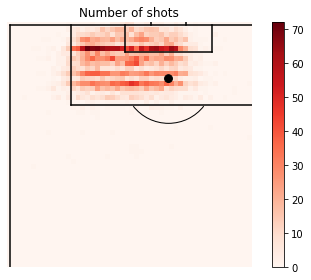

In [171]:
#Two dimensional histogram
H_Shot=np.histogram2d(shots.X0, shots.Y0,bins=50,range=[[0, pitchLengthX],[0, pitchWidthY]])
goals_only=shots[shots.goal==1]
H_Goal=np.histogram2d(goals_only.X0, goals_only.Y0,bins=50,range=[[0, pitchLengthX],[0, pitchWidthY]])

#Plot the number of shots from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Shot[0], 
#               extent=[-0.5,68,105,0], 
              aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
# plt.xlim((-1,66))
# plt.ylim((0,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [140]:
shots[['goal','X0','Y0','distance','angle']].head()

,goal,X0,Y0,distance,angle
0,1,92.40,27.88,14.007655,1.569891
1,0,89.25,35.36,15.808608,1.567103
2,0,85.05,22.44,23.057235,1.555279
3,0,78.75,20.40,29.563872,1.542756
4,0,94.50,26.52,12.891873,1.571525


In [139]:
shots_model.head()

,Goal,X,Y,C,Distance,Angle,xG,D2
0,1,12,41,9.0,13.891814,0.474451,0.171271,192.9825
1,0,15,52,2.0,15.803560,0.453823,0.162665,249.7525
3,0,19,33,17.0,22.805811,0.280597,0.103567,520.1050
4,0,25,30,20.0,29.292704,0.223680,0.088753,858.0625
5,0,10,39,11.0,12.703248,0.479051,0.173239,161.3725


In [176]:
len(shots)

7134

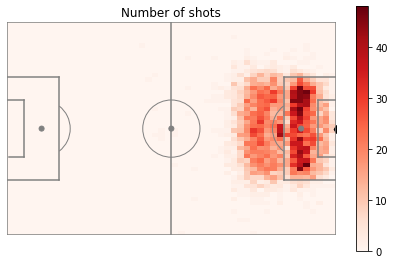

In [220]:
import sys
%matplotlib inline
sys.path.append("/mnt/d/xFootball/SoccermaticsForPython/")#os.getcwd() + '/modules')
from FCPython import createPitch
pitchLengthX=105
pitchWidthY=68
(fig,ax) = createPitch(length=pitchLengthX,width=pitchWidthY,unity='meters',linecolor='gray')

# for shot in shots.sample(200).itertuples():
    
#     ax.scatter(shot.X0,shot.Y0,
#                s=20, 
#                color='green' if shot.goal==1 else 'red', 
#                alpha = 1 if shot.goal==1 else 0.3, 
#                zorder=3 if shot.goal==1 else 2,
#                marker='o')
#     ax.plot([shot.X0,shot.G_X],[shot.Y0,shot.G_Y], color='black', ls='--')
ax.scatter(shot.G_X,shot.G_Y,s=30, marker='d', color='black')    

H_Shot=np.histogram2d(shots.Y0,shots.X0, bins=50,range=[[0,pitchWidthY ],[0, pitchLengthX]])
goals_only=shots[shots.goal==1]
H_Goal=np.histogram2d(goals_only.X0, goals_only.Y0,bins=50,range=[[0, pitchLengthX],[0, pitchWidthY]])
pos = ax.imshow(H_Shot[0],extent=[0,pitchLengthX,0,pitchWidthY],aspect='auto',cmap=plt.cm.Reds, zorder=0)
# plt.xlim((-1,106))
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')

In [187]:
H_Shot[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

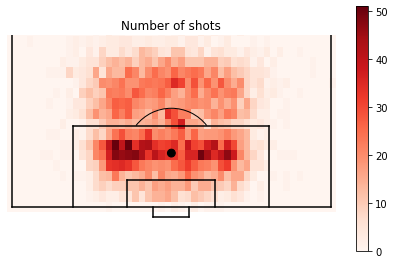

In [64]:
shots_model=pd.DataFrame(columns=['Goal','X','Y'])

#Go through the dataframe and calculate X, Y co-ordinates.
#Distance from a line in the centre
#Shot angle.
#Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events
for i,shot in shots.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1

#Two dimensional histogram
H_Shot=np.histogram2d(shots_model['X'], shots_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_model[shots_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])



#Plot the number of shots from different points
from FCPython import createGoalMouth
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

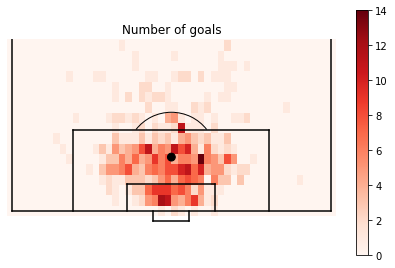

In [71]:
#Plot the number of GOALS from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


/home/opunsoars/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


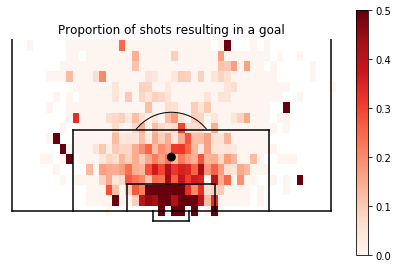

In [72]:
#Plot the probability of scoring from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

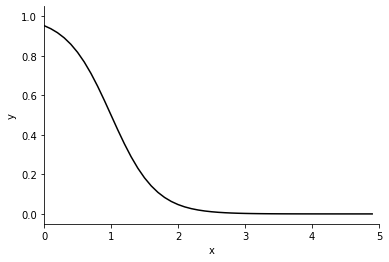

In [73]:
#Plot a logistic curve
b=[3, -3]
x=np.arange(5,step=0.1)
y=1/(1+np.exp(-b[0]-b[1]*x))
fig,ax=plt.subplots(num=1)
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x") 
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


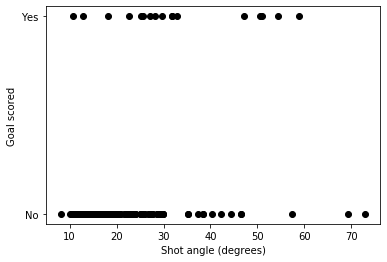

In [221]:
shots_200=shots_model.iloc[:200]

#Plot first 200 shots goal angle
fig,ax=plt.subplots(num=1)
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

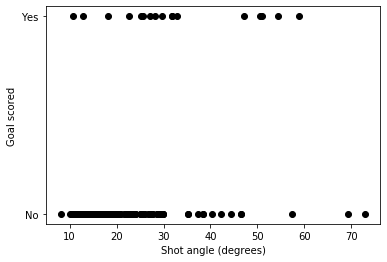

In [74]:
#Get first 200 shots
shots_200=shots_model.iloc[:200]

#Plot first 200 shots goal angle
fig,ax=plt.subplots(num=1)
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

In [76]:
shots_200

,Goal,X,Y,C,Distance,Angle
0,1,12,41,9.0,13.891814,0.474451
1,0,15,52,2.0,15.803560,0.453823
3,0,19,33,17.0,22.805811,0.280597
4,0,25,30,20.0,29.292704,0.223680
5,0,10,39,11.0,12.703248,0.479051
...,...,...,...,...,...,...
236,0,13,37,13.0,16.053816,0.388196
237,0,3,45,5.0,4.526036,1.272510
238,0,17,63,13.0,19.749051,0.333932
240,0,5,62,12.0,9.402260,0.473481


/home/opunsoars/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


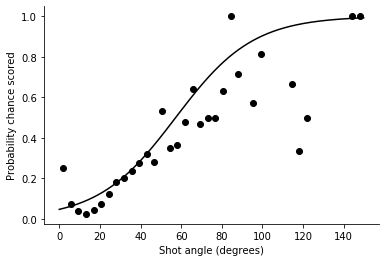

In [80]:
#Show empirically how goal angle predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
b=[3, -3]
x=np.arange(150,step=0.1)
y=1/(1+np.exp(b[0]+b[1]*x*np.pi/180)) 
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

In [83]:
#Now lets look at the likelihood of model given data
xG=1/(1+np.exp(b[0]+b[1]*shots_model['Angle'])) 
shots_model = shots_model.assign(xG=xG)
shots_40=shots_model.iloc[:40]
shots_40.head()

,Goal,X,Y,C,Distance,Angle,xG
0,1,12,41,9.0,13.891814,0.474451,0.171271
1,0,15,52,2.0,15.803560,0.453823,0.162665
3,0,19,33,17.0,22.805811,0.280597,0.103567
4,0,25,30,20.0,29.292704,0.223680,0.088753
5,0,10,39,11.0,12.703248,0.479051,0.173239


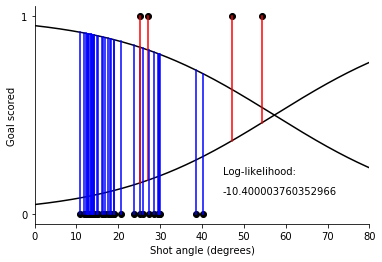

In [85]:
fig,ax=plt.subplots(num=1)
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(x, y, linestyle='solid', color='black')
ax.plot(x, 1-y, linestyle='solid', color='black')
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang=shot['Angle']*180/np.pi
    if shot['Goal']==1:
        loglikelihood=loglikelihood+np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],shot['xG']], color='red')
    else:
        loglikelihood=loglikelihood+np.log(1 - shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='blue')
    
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,80))
plt.text(45,0.2,'Log-likelihood:') 
plt.text(45,0.1,str(loglikelihood))
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.savefig('Output/LikelihoodExample.pdf', dpi=None, bbox_inches="tight")   
plt.show()

In [86]:
#Make single variable model of angle
#Using logistic regression we find the optimal values of b
#This process minimizes the loglikelihood
test_model = smf.glm(formula="Goal ~ Angle" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7132
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2056.3
Date:                    Fri, 18 Sep 2020   Deviance:                       4112.7
Time:                            11:57:32   Pearson chi2:                 6.70e+03
No. Iterations:                         6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

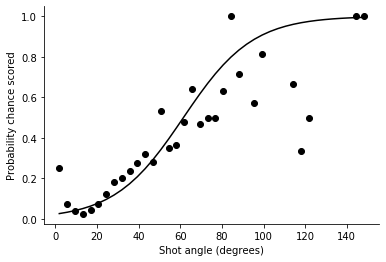

In [87]:
xGprob=1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

/home/opunsoars/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7132
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2010.7
Date:                    Fri, 18 Sep 2020   Deviance:                       4021.3
Time:                            12:02:11   Pearson chi2:                 1.90e+04
No. Iterations:                         6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

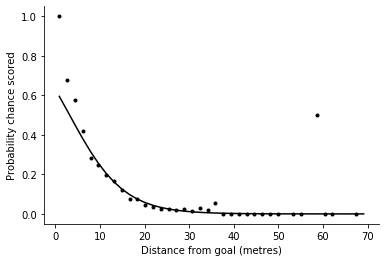

In [90]:
#Now lets look at distance from goal


#Show empirically how distance from goal predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Make single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance)) 
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7131
Model Family:                    Binomial   Df Model:                            2
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1992.2
Date:                    Fri, 18 Sep 2020   Deviance:                       3984.3
Time:                            12:02:26   Pearson chi2:                 7.12e+03
No. Iterations:                         7                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

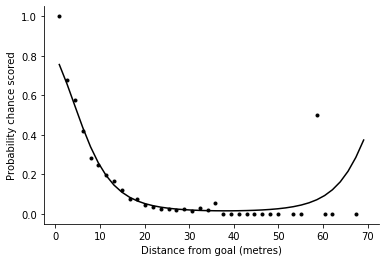

In [91]:
#Adding distance squared
squaredD = shots_model['Distance']**2
shots_model = shots_model.assign(D2=squaredD)
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2))) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()